In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 98% !important }<style>"))

# Analysis

In [2]:
from utilities import *
from models import *

In [3]:
pin_file = "../Data/pin.csv"

pin = read_pin(pin_file)

In [4]:
filename = "../Data/rssi4.csv"
B1 = "0117C55D14E4"

data = read_data(filename, B1)

All beacons: ['0117C55D14E4']
Selecting 0117C55D14E4


In [5]:
data[scanners] = minMaxScaling(data[scanners])

In [6]:
data_grouped = data.groupby(["location", pd.Grouper(key="time", freq="1s")]).mean().reset_index()

## Train Validation Test Split

In [7]:
train, validation, test = train_validation_test_split(data_grouped)

In [8]:
train.groupby("location")[scanners].count()

,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,E6D9D20DD197,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C
location,,,,,,,,,,,,,,,,,
V1_11,37,46,38,48,49,47,41,49,45,31,38,52,51,19,18,19,43
V1_12,53,43,36,56,53,52,35,37,64,38,43,65,64,41,53,40,44
V1_13,39,55,37,50,31,44,48,48,67,11,31,50,48,50,51,13,41
V1_14,27,64,34,42,37,49,62,39,65,9,64,32,49,40,52,41,46
V1_20,61,58,56,53,56,53,45,44,47,25,40,51,67,11,38,19,41
V1_21,44,57,39,48,54,48,58,39,63,18,48,49,43,41,41,37,39
V1_22,45,45,38,46,41,64,67,24,64,24,66,43,36,7,53,51,32
V1_23,40,47,42,37,26,73,63,34,76,23,64,43,48,7,59,55,31
V1_24,16,37,39,34,30,47,47,31,64,15,56,33,42,16,36,51,17


In [9]:
validation.shape

(344, 19)

In [10]:
test.shape

(344, 19)

In [11]:
train.sort_values("time", inplace=True)
validation.sort_values("time", inplace=True)
test.sort_values("time", inplace=True)

## Imputation
1. Forward fill
2. Fill NaN

In [12]:
train_imputed = train.set_index("location").groupby("location").ffill()
train_imputed.fillna(0, inplace=True)
train_imputed.reset_index(inplace=True)

In [13]:
validation_imputed = validation.set_index("location").groupby("location").ffill()
validation_imputed.fillna(0, inplace=True)
validation_imputed.reset_index(inplace=True)

In [14]:
test_imputed = test.set_index("location").groupby("location").ffill()
test_imputed.fillna(0, inplace=True)
test_imputed.reset_index(inplace=True)

## Change Location to Coordinates

In [15]:
train_imputed["X"] = train_imputed["location"].apply(lambda x: pin[x]["X"])
train_imputed["Y"] = train_imputed["location"].apply(lambda x: pin[x]["Y"])

In [16]:
validation_imputed["X"] = validation_imputed["location"].apply(lambda x: pin[x]["X"])
validation_imputed["Y"] = validation_imputed["location"].apply(lambda x: pin[x]["Y"])

In [17]:
test_imputed["X"] = test_imputed["location"].apply(lambda x: pin[x]["X"])
test_imputed["Y"] = test_imputed["location"].apply(lambda x: pin[x]["Y"])

## Model Training

In [18]:
X_train, y_train = train_imputed[scanners].values, train_imputed[["X", "Y"]].values
X_validation, y_validation = validation_imputed[scanners].values, validation_imputed[["X", "Y"]].values
X_test, y_test = test_imputed[scanners].values, test_imputed[["X", "Y"]].values

In [19]:
model = MLP(size='small')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 642
Trainable params: 642
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_train, y_train, X_validation, y_validation)

Train on 1030 samples, validate on 344 samples
Epoch 1/1000
1030/1030 [==============================] - 1s 593us/sample - loss: 276.9697 - mae: 14.9914 - mse: 276.9034 - val_loss: 262.9070 - val_mae: 14.6224 - val_mse: 262.8294
Epoch 2/1000
1030/1030 [==============================] - 0s 52us/sample - loss: 254.9735 - mae: 14.3669 - mse: 254.8685 - val_loss: 239.9541 - val_mae: 13.9325 - val_mse: 239.8114
Epoch 3/1000
1030/1030 [==============================] - 0s 52us/sample - loss: 229.5449 - mae: 13.5805 - mse: 229.3386 - val_loss: 213.6350 - val_mae: 13.0614 - val_mse: 213.3506
Epoch 4/1000
1030/1030 [==============================] - 0s 45us/sample - loss: 201.1832 - mae: 12.5923 - mse: 200.7761 - val_loss: 184.2776 - val_mae: 11.9637 - val_mse: 183.7294
Epoch 5/1000
1030/1030 [==============================] - 0s 43us/sample - loss: 169.8867 - mae: 11.3596 - mse: 169.1232 - val_loss: 152.7090 - val_mae: 10.6315 - val_mse: 151.7102
Epoch 6/1000
1030/1030 [=======================

1030/1030 [==============================] - 0s 46us/sample - loss: 15.0321 - mae: 1.7249 - mse: 4.4232 - val_loss: 16.1569 - val_mae: 1.8083 - val_mse: 5.8617
Epoch 48/1000
1030/1030 [==============================] - 0s 45us/sample - loss: 14.9525 - mae: 1.7017 - mse: 4.3047 - val_loss: 16.0475 - val_mae: 1.7740 - val_mse: 5.6768
Epoch 49/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 14.8641 - mae: 1.6790 - mse: 4.1970 - val_loss: 15.9754 - val_mae: 1.8098 - val_mse: 5.7982
Epoch 50/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 14.7961 - mae: 1.6675 - mse: 4.1353 - val_loss: 15.8887 - val_mae: 1.8107 - val_mse: 5.7427
Epoch 51/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 14.7123 - mae: 1.6481 - mse: 4.0585 - val_loss: 15.7530 - val_mae: 1.7962 - val_mse: 5.5297
Epoch 52/1000
1030/1030 [==============================] - 0s 42us/sample - loss: 14.6297 - mae: 1.6326 - mse: 3.9584 - val_loss: 15.6284 - val_

1030/1030 [==============================] - 0s 45us/sample - loss: 13.2804 - mae: 1.2254 - mse: 2.4134 - val_loss: 13.8441 - val_mae: 1.2905 - val_mse: 3.1602
Epoch 95/1000
1030/1030 [==============================] - 0s 44us/sample - loss: 13.2737 - mae: 1.2186 - mse: 2.3902 - val_loss: 13.8448 - val_mae: 1.3173 - val_mse: 3.2519
Epoch 96/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 13.2606 - mae: 1.2142 - mse: 2.3823 - val_loss: 13.8572 - val_mae: 1.2897 - val_mse: 3.1534
Epoch 97/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 13.2439 - mae: 1.2103 - mse: 2.3644 - val_loss: 13.9404 - val_mae: 1.3750 - val_mse: 3.4593
Epoch 98/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 13.2395 - mae: 1.2095 - mse: 2.3662 - val_loss: 13.8313 - val_mae: 1.3145 - val_mse: 3.2291
Epoch 99/1000
1030/1030 [==============================] - 0s 43us/sample - loss: 13.2277 - mae: 1.2084 - mse: 2.3450 - val_loss: 13.7940 - val_

Epoch 141/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.9613 - mae: 1.1210 - mse: 2.0547 - val_loss: 13.3943 - val_mae: 1.1899 - val_mse: 2.6054
Epoch 142/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.9515 - mae: 1.1174 - mse: 2.0429 - val_loss: 13.3919 - val_mae: 1.2220 - val_mse: 2.7069
Epoch 143/1000
1030/1030 [==============================] - 0s 60us/sample - loss: 12.9522 - mae: 1.1224 - mse: 2.0577 - val_loss: 13.4234 - val_mae: 1.1768 - val_mse: 2.5618
Epoch 144/1000
1030/1030 [==============================] - 0s 50us/sample - loss: 12.9496 - mae: 1.1102 - mse: 2.0265 - val_loss: 13.4399 - val_mae: 1.2485 - val_mse: 2.7849
Epoch 145/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.9411 - mae: 1.1163 - mse: 2.0393 - val_loss: 13.3906 - val_mae: 1.1988 - val_mse: 2.6215
Epoch 146/1000
1030/1030 [==============================] - 0s 58us/sample - loss: 12.9361 - mae: 1.1110 - mse: 2.0229 - val_

Epoch 188/1000
1030/1030 [==============================] - 0s 45us/sample - loss: 12.8024 - mae: 1.0730 - mse: 1.9166 - val_loss: 13.2416 - val_mae: 1.1359 - val_mse: 2.3569
Epoch 189/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.7985 - mae: 1.0608 - mse: 1.8747 - val_loss: 13.2056 - val_mae: 1.1379 - val_mse: 2.3682
Epoch 190/1000
1030/1030 [==============================] - 0s 45us/sample - loss: 12.7986 - mae: 1.0654 - mse: 1.8870 - val_loss: 13.2474 - val_mae: 1.1209 - val_mse: 2.3118
Epoch 191/1000
1030/1030 [==============================] - 0s 39us/sample - loss: 12.7956 - mae: 1.0597 - mse: 1.8703 - val_loss: 13.2213 - val_mae: 1.1518 - val_mse: 2.4023
Epoch 192/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.7921 - mae: 1.0612 - mse: 1.8707 - val_loss: 13.2007 - val_mae: 1.1683 - val_mse: 2.4517
Epoch 193/1000
1030/1030 [==============================] - 0s 39us/sample - loss: 12.7903 - mae: 1.0639 - mse: 1.8736 - val_

Epoch 235/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.7190 - mae: 1.0481 - mse: 1.8368 - val_loss: 13.1947 - val_mae: 1.2219 - val_mse: 2.5857
Epoch 236/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.7038 - mae: 1.0450 - mse: 1.8287 - val_loss: 13.2298 - val_mae: 1.0441 - val_mse: 2.0687
Epoch 237/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.7089 - mae: 1.0294 - mse: 1.7764 - val_loss: 13.1191 - val_mae: 1.1034 - val_mse: 2.2469
Epoch 238/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.7095 - mae: 1.0351 - mse: 1.7989 - val_loss: 13.1359 - val_mae: 1.1956 - val_mse: 2.5152
Epoch 239/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.7085 - mae: 1.0438 - mse: 1.8269 - val_loss: 13.1216 - val_mae: 1.1030 - val_mse: 2.2437
Epoch 240/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.7042 - mae: 1.0317 - mse: 1.7854 - val_

Epoch 282/1000
1030/1030 [==============================] - 0s 45us/sample - loss: 12.6459 - mae: 1.0206 - mse: 1.7591 - val_loss: 13.0620 - val_mae: 1.1395 - val_mse: 2.3384
Epoch 283/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 12.6475 - mae: 1.0233 - mse: 1.7681 - val_loss: 13.0927 - val_mae: 1.1221 - val_mse: 2.2771
Epoch 284/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.6453 - mae: 1.0223 - mse: 1.7564 - val_loss: 13.0619 - val_mae: 1.1561 - val_mse: 2.3944
Epoch 285/1000
1030/1030 [==============================] - 0s 39us/sample - loss: 12.6427 - mae: 1.0243 - mse: 1.7683 - val_loss: 13.1141 - val_mae: 1.0847 - val_mse: 2.1679
Epoch 286/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 12.6401 - mae: 1.0196 - mse: 1.7484 - val_loss: 13.1308 - val_mae: 1.1308 - val_mse: 2.2967
Epoch 287/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.6403 - mae: 1.0149 - mse: 1.7315 - val_

Epoch 329/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.5940 - mae: 1.0096 - mse: 1.7235 - val_loss: 13.0626 - val_mae: 1.1426 - val_mse: 2.3267
Epoch 330/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.5890 - mae: 1.0135 - mse: 1.7232 - val_loss: 13.0234 - val_mae: 1.0977 - val_mse: 2.2218
Epoch 331/1000
1030/1030 [==============================] - 0s 42us/sample - loss: 12.5898 - mae: 1.0083 - mse: 1.7095 - val_loss: 13.0524 - val_mae: 1.0860 - val_mse: 2.1735
Epoch 332/1000
1030/1030 [==============================] - 0s 45us/sample - loss: 12.5913 - mae: 1.0011 - mse: 1.7010 - val_loss: 13.0522 - val_mae: 1.1964 - val_mse: 2.5033
Epoch 333/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.5850 - mae: 1.0154 - mse: 1.7421 - val_loss: 13.0438 - val_mae: 1.1022 - val_mse: 2.2160
Epoch 334/1000
1030/1030 [==============================] - 0s 44us/sample - loss: 12.5870 - mae: 1.0049 - mse: 1.7033 - val_

Epoch 376/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.5433 - mae: 0.9898 - mse: 1.6515 - val_loss: 13.0481 - val_mae: 1.2203 - val_mse: 2.5689
Epoch 377/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.5404 - mae: 1.0046 - mse: 1.7023 - val_loss: 13.0274 - val_mae: 1.1303 - val_mse: 2.2915
Epoch 378/1000
1030/1030 [==============================] - 0s 34us/sample - loss: 12.5471 - mae: 0.9984 - mse: 1.6888 - val_loss: 13.0211 - val_mae: 1.1744 - val_mse: 2.4267
Epoch 379/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.5423 - mae: 1.0006 - mse: 1.6912 - val_loss: 13.0101 - val_mae: 1.1599 - val_mse: 2.3872
Epoch 380/1000
1030/1030 [==============================] - 0s 34us/sample - loss: 12.5445 - mae: 1.0008 - mse: 1.6935 - val_loss: 12.9887 - val_mae: 1.1035 - val_mse: 2.2314
Epoch 381/1000
1030/1030 [==============================] - 0s 35us/sample - loss: 12.5419 - mae: 0.9985 - mse: 1.6827 - val_

Epoch 423/1000
1030/1030 [==============================] - 0s 65us/sample - loss: 12.5089 - mae: 0.9906 - mse: 1.6680 - val_loss: 12.9939 - val_mae: 1.1059 - val_mse: 2.2146
Epoch 424/1000
1030/1030 [==============================] - 0s 61us/sample - loss: 12.5083 - mae: 0.9851 - mse: 1.6424 - val_loss: 12.9532 - val_mae: 1.0841 - val_mse: 2.1765
Epoch 425/1000
1030/1030 [==============================] - 0s 64us/sample - loss: 12.5077 - mae: 0.9875 - mse: 1.6495 - val_loss: 12.9838 - val_mae: 1.0764 - val_mse: 2.1409
Epoch 426/1000
1030/1030 [==============================] - 0s 51us/sample - loss: 12.5094 - mae: 0.9840 - mse: 1.6496 - val_loss: 12.9681 - val_mae: 1.0621 - val_mse: 2.1122
Epoch 427/1000
1030/1030 [==============================] - 0s 56us/sample - loss: 12.5061 - mae: 0.9836 - mse: 1.6409 - val_loss: 12.9880 - val_mae: 1.1668 - val_mse: 2.4042
Epoch 428/1000
1030/1030 [==============================] - 0s 53us/sample - loss: 12.4974 - mae: 0.9898 - mse: 1.6541 - val_

Epoch 470/1000
1030/1030 [==============================] - 0s 42us/sample - loss: 12.4703 - mae: 0.9803 - mse: 1.6337 - val_loss: 12.9535 - val_mae: 1.1424 - val_mse: 2.3381
Epoch 471/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.4765 - mae: 0.9827 - mse: 1.6435 - val_loss: 12.9861 - val_mae: 1.1827 - val_mse: 2.4480
Epoch 472/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.4723 - mae: 0.9869 - mse: 1.6511 - val_loss: 12.9288 - val_mae: 1.1135 - val_mse: 2.2653
Epoch 473/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.4711 - mae: 0.9835 - mse: 1.6385 - val_loss: 12.9693 - val_mae: 1.0579 - val_mse: 2.0840
Epoch 474/1000
1030/1030 [==============================] - 0s 59us/sample - loss: 12.4705 - mae: 0.9773 - mse: 1.6169 - val_loss: 12.9521 - val_mae: 1.1044 - val_mse: 2.2221
Epoch 475/1000
1030/1030 [==============================] - 0s 75us/sample - loss: 12.4720 - mae: 0.9779 - mse: 1.6341 - val_

Epoch 517/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.4489 - mae: 0.9781 - mse: 1.6218 - val_loss: 12.9584 - val_mae: 1.0654 - val_mse: 2.1017
Epoch 518/1000
1030/1030 [==============================] - 0s 49us/sample - loss: 12.4422 - mae: 0.9691 - mse: 1.5976 - val_loss: 12.9272 - val_mae: 1.0805 - val_mse: 2.1566
Epoch 519/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.4388 - mae: 0.9732 - mse: 1.6124 - val_loss: 13.0000 - val_mae: 1.0619 - val_mse: 2.0832
Epoch 520/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.4461 - mae: 0.9690 - mse: 1.5991 - val_loss: 12.9238 - val_mae: 1.1594 - val_mse: 2.4019
Epoch 521/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.4406 - mae: 0.9813 - mse: 1.6351 - val_loss: 12.9581 - val_mae: 1.0187 - val_mse: 1.9892
Epoch 522/1000
1030/1030 [==============================] - 0s 43us/sample - loss: 12.4435 - mae: 0.9700 - mse: 1.6012 - val_

Epoch 564/1000
1030/1030 [==============================] - 0s 44us/sample - loss: 12.4216 - mae: 0.9731 - mse: 1.6154 - val_loss: 12.8861 - val_mae: 1.0872 - val_mse: 2.2055
Epoch 565/1000
1030/1030 [==============================] - 0s 49us/sample - loss: 12.4178 - mae: 0.9689 - mse: 1.5993 - val_loss: 12.9486 - val_mae: 1.1363 - val_mse: 2.3070
Epoch 566/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.4168 - mae: 0.9672 - mse: 1.5955 - val_loss: 12.9347 - val_mae: 1.1682 - val_mse: 2.4100
Epoch 567/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.4213 - mae: 0.9715 - mse: 1.6137 - val_loss: 12.9116 - val_mae: 1.0761 - val_mse: 2.1433
Epoch 568/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.4164 - mae: 0.9636 - mse: 1.5869 - val_loss: 12.9090 - val_mae: 1.0687 - val_mse: 2.1208
Epoch 569/1000
1030/1030 [==============================] - 0s 43us/sample - loss: 12.4177 - mae: 0.9660 - mse: 1.5874 - val_

Epoch 611/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.3943 - mae: 0.9698 - mse: 1.6066 - val_loss: 12.9279 - val_mae: 1.0318 - val_mse: 2.0180
Epoch 612/1000
1030/1030 [==============================] - 0s 45us/sample - loss: 12.3934 - mae: 0.9520 - mse: 1.5557 - val_loss: 12.9071 - val_mae: 1.1586 - val_mse: 2.3895
Epoch 613/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.3885 - mae: 0.9672 - mse: 1.5954 - val_loss: 12.9203 - val_mae: 1.0122 - val_mse: 1.9757
Epoch 614/1000
1030/1030 [==============================] - 0s 43us/sample - loss: 12.3980 - mae: 0.9605 - mse: 1.5754 - val_loss: 12.9158 - val_mae: 1.0726 - val_mse: 2.1223
Epoch 615/1000
1030/1030 [==============================] - 0s 42us/sample - loss: 12.3969 - mae: 0.9602 - mse: 1.5779 - val_loss: 12.9085 - val_mae: 1.0981 - val_mse: 2.1942
Epoch 616/1000
1030/1030 [==============================] - 0s 38us/sample - loss: 12.3894 - mae: 0.9602 - mse: 1.5657 - val_

Epoch 658/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.3708 - mae: 0.9478 - mse: 1.5371 - val_loss: 12.8909 - val_mae: 1.1080 - val_mse: 2.2229
Epoch 659/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.3780 - mae: 0.9613 - mse: 1.5815 - val_loss: 12.9060 - val_mae: 1.1380 - val_mse: 2.3080
Epoch 660/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.3708 - mae: 0.9576 - mse: 1.5636 - val_loss: 12.8757 - val_mae: 1.1116 - val_mse: 2.2415
Epoch 661/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.3678 - mae: 0.9591 - mse: 1.5672 - val_loss: 12.8551 - val_mae: 1.0957 - val_mse: 2.2104
Epoch 662/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.3717 - mae: 0.9579 - mse: 1.5630 - val_loss: 12.8515 - val_mae: 1.1069 - val_mse: 2.2462
Epoch 663/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 12.3705 - mae: 0.9578 - mse: 1.5697 - val_

Epoch 705/1000
1030/1030 [==============================] - 0s 51us/sample - loss: 12.3531 - mae: 0.9512 - mse: 1.5406 - val_loss: 12.9165 - val_mae: 1.1536 - val_mse: 2.3489
Epoch 706/1000
1030/1030 [==============================] - 0s 43us/sample - loss: 12.3522 - mae: 0.9588 - mse: 1.5602 - val_loss: 12.8587 - val_mae: 1.0496 - val_mse: 2.0671
Epoch 707/1000
1030/1030 [==============================] - 0s 43us/sample - loss: 12.3538 - mae: 0.9521 - mse: 1.5483 - val_loss: 12.8429 - val_mae: 1.1071 - val_mse: 2.2411
Epoch 708/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.3517 - mae: 0.9564 - mse: 1.5546 - val_loss: 12.8668 - val_mae: 1.0439 - val_mse: 2.0524
Epoch 709/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.3557 - mae: 0.9525 - mse: 1.5478 - val_loss: 12.8566 - val_mae: 1.0818 - val_mse: 2.1655
Epoch 710/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.3556 - mae: 0.9558 - mse: 1.5600 - val_

Epoch 752/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.3377 - mae: 0.9517 - mse: 1.5440 - val_loss: 12.8888 - val_mae: 1.0409 - val_mse: 2.0355
Epoch 753/1000
1030/1030 [==============================] - 0s 43us/sample - loss: 12.3361 - mae: 0.9509 - mse: 1.5411 - val_loss: 12.9294 - val_mae: 0.9783 - val_mse: 1.8743
Epoch 754/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.3341 - mae: 0.9383 - mse: 1.5120 - val_loss: 12.8311 - val_mae: 1.0895 - val_mse: 2.1892
Epoch 755/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.3329 - mae: 0.9513 - mse: 1.5406 - val_loss: 12.8671 - val_mae: 1.1299 - val_mse: 2.2963
Epoch 756/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.3354 - mae: 0.9550 - mse: 1.5581 - val_loss: 12.9142 - val_mae: 1.0053 - val_mse: 1.9370
Epoch 757/1000
1030/1030 [==============================] - 0s 42us/sample - loss: 12.3334 - mae: 0.9394 - mse: 1.5136 - val_

Epoch 799/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.3190 - mae: 0.9499 - mse: 1.5462 - val_loss: 12.8643 - val_mae: 1.0487 - val_mse: 2.0568
Epoch 800/1000
1030/1030 [==============================] - 0s 45us/sample - loss: 12.3193 - mae: 0.9427 - mse: 1.5159 - val_loss: 12.8194 - val_mae: 1.1025 - val_mse: 2.2329
Epoch 801/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 12.3180 - mae: 0.9441 - mse: 1.5254 - val_loss: 12.8382 - val_mae: 1.1466 - val_mse: 2.3552
Epoch 802/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.3223 - mae: 0.9537 - mse: 1.5544 - val_loss: 12.8130 - val_mae: 1.0518 - val_mse: 2.0813
Epoch 803/1000
1030/1030 [==============================] - 0s 38us/sample - loss: 12.3213 - mae: 0.9439 - mse: 1.5220 - val_loss: 12.8288 - val_mae: 1.0621 - val_mse: 2.1047
Epoch 804/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 12.3203 - mae: 0.9439 - mse: 1.5272 - val_

Epoch 846/1000
1030/1030 [==============================] - 0s 39us/sample - loss: 12.3036 - mae: 0.9427 - mse: 1.5158 - val_loss: 12.8127 - val_mae: 1.1307 - val_mse: 2.3268
Epoch 847/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.3034 - mae: 0.9484 - mse: 1.5411 - val_loss: 12.8417 - val_mae: 1.0103 - val_mse: 1.9687
Epoch 848/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.3019 - mae: 0.9381 - mse: 1.5055 - val_loss: 12.9081 - val_mae: 0.9938 - val_mse: 1.9060
Epoch 849/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.3072 - mae: 0.9359 - mse: 1.4987 - val_loss: 12.8359 - val_mae: 1.1108 - val_mse: 2.2350
Epoch 850/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.2998 - mae: 0.9402 - mse: 1.5080 - val_loss: 12.8315 - val_mae: 1.0873 - val_mse: 2.1714
Epoch 851/1000
1030/1030 [==============================] - 0s 43us/sample - loss: 12.3003 - mae: 0.9456 - mse: 1.5222 - val_

Epoch 893/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.2879 - mae: 0.9367 - mse: 1.5030 - val_loss: 12.8714 - val_mae: 1.1710 - val_mse: 2.4080
Epoch 894/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.2893 - mae: 0.9485 - mse: 1.5320 - val_loss: 12.8034 - val_mae: 1.1248 - val_mse: 2.3047
Epoch 895/1000
1030/1030 [==============================] - 0s 39us/sample - loss: 12.2925 - mae: 0.9481 - mse: 1.5371 - val_loss: 12.8223 - val_mae: 1.0135 - val_mse: 1.9726
Epoch 896/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.2915 - mae: 0.9327 - mse: 1.4924 - val_loss: 12.8367 - val_mae: 1.0787 - val_mse: 2.1401
Epoch 897/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 12.2856 - mae: 0.9351 - mse: 1.4907 - val_loss: 12.8146 - val_mae: 1.1161 - val_mse: 2.2603
Epoch 898/1000
1030/1030 [==============================] - 0s 39us/sample - loss: 12.2893 - mae: 0.9448 - mse: 1.5230 - val_

Epoch 940/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.2785 - mae: 0.9263 - mse: 1.4774 - val_loss: 12.7921 - val_mae: 1.0952 - val_mse: 2.2010
Epoch 941/1000
1030/1030 [==============================] - 0s 39us/sample - loss: 12.2803 - mae: 0.9428 - mse: 1.5156 - val_loss: 12.8349 - val_mae: 0.9922 - val_mse: 1.9222
Epoch 942/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.2791 - mae: 0.9312 - mse: 1.4922 - val_loss: 12.8266 - val_mae: 0.9999 - val_mse: 1.9499
Epoch 943/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.2796 - mae: 0.9310 - mse: 1.4898 - val_loss: 12.8217 - val_mae: 1.0106 - val_mse: 1.9677
Epoch 944/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.2777 - mae: 0.9298 - mse: 1.4836 - val_loss: 12.7965 - val_mae: 1.0914 - val_mse: 2.1929
Epoch 945/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.2774 - mae: 0.9406 - mse: 1.5167 - val_

Epoch 987/1000
1030/1030 [==============================] - 0s 45us/sample - loss: 12.2658 - mae: 0.9390 - mse: 1.5045 - val_loss: 12.8011 - val_mae: 1.0200 - val_mse: 1.9935
Epoch 988/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.2683 - mae: 0.9298 - mse: 1.4812 - val_loss: 12.8011 - val_mae: 1.0767 - val_mse: 2.1440
Epoch 989/1000
1030/1030 [==============================] - 0s 45us/sample - loss: 12.2652 - mae: 0.9347 - mse: 1.4961 - val_loss: 12.7795 - val_mae: 1.0971 - val_mse: 2.2313
Epoch 990/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.2684 - mae: 0.9325 - mse: 1.4891 - val_loss: 12.7939 - val_mae: 1.1147 - val_mse: 2.2744
Epoch 991/1000
1030/1030 [==============================] - 0s 39us/sample - loss: 12.2652 - mae: 0.9388 - mse: 1.5071 - val_loss: 12.7901 - val_mae: 1.0255 - val_mse: 2.0244
Epoch 992/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 12.2664 - mae: 0.9314 - mse: 1.4927 - val_

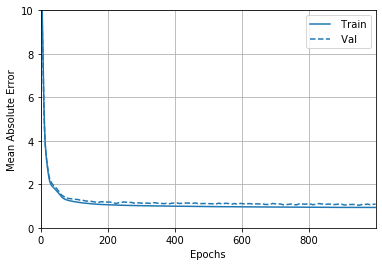

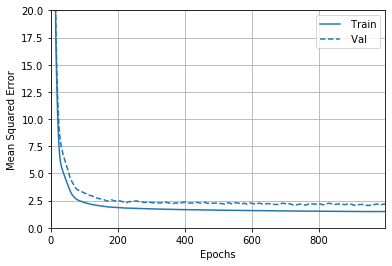

In [21]:
model.show_history()

## Model Validation

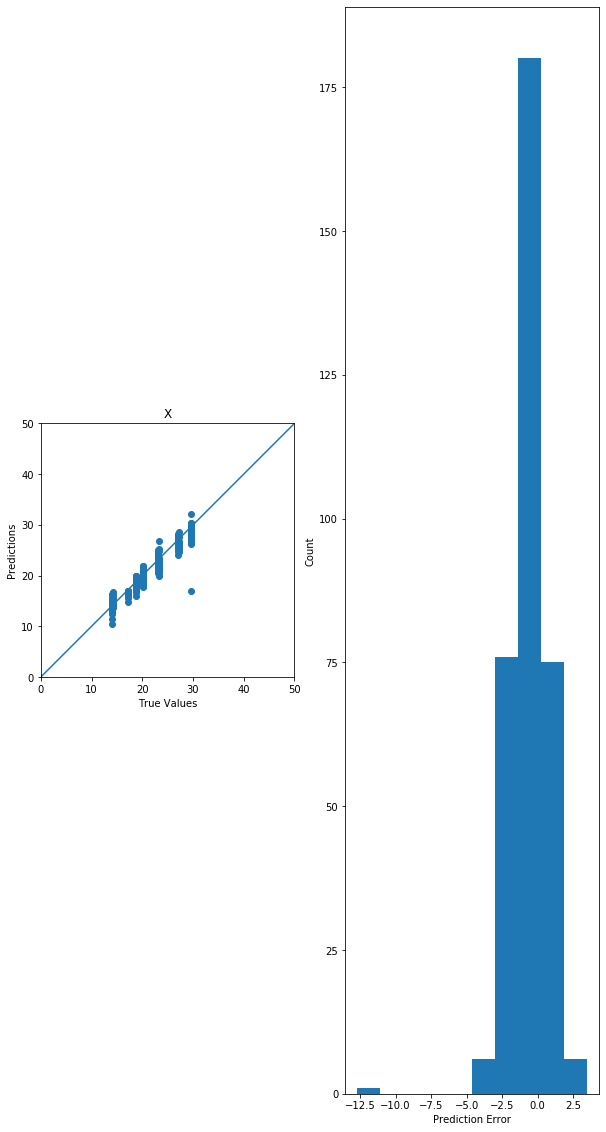

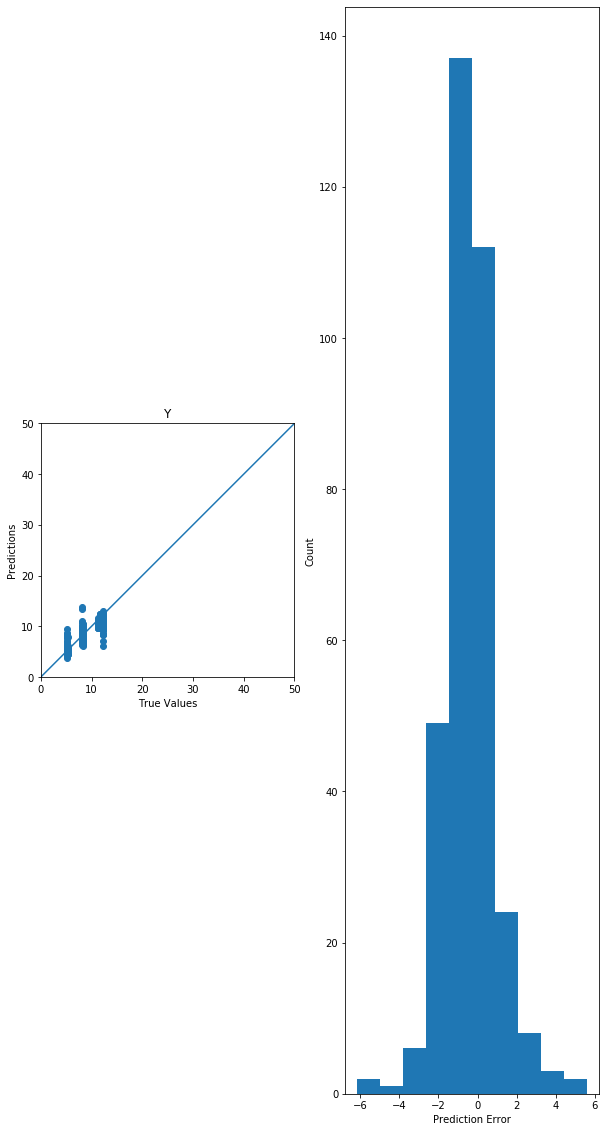

In [22]:
model.model_validation(X_validation, y_validation)

## Model Testing

In [23]:
model.model_testing(X_test, y_test)

344/1 - 0s - loss: 10.8523 - mae: 1.0750 - mse: 1.9500
Test loss: 13.149299377618833
Mean absolute error: 1.0750041
Mean squared error: 1.9499893


## Plotting Learning Curves

In [24]:
train_loss = []
val_loss = []

for f in range(1, 11, 1):
    frac = f / 10.0
    sample = data_grouped.sample(frac=frac, random_state=12345)
    sample_grouped = sample.groupby(["location", pd.Grouper(key="time", freq="1s")]).mean().reset_index()
    train, validation, test = train_validation_test_split(sample_grouped)

    train.sort_values("time", inplace=True)
    validation.sort_values("time", inplace=True)
    test.sort_values("time", inplace=True)

    train_imputed = train.set_index("location").groupby("location").ffill()
    train_imputed.fillna(0, inplace=True)
    train_imputed.reset_index(inplace=True)

    validation_imputed = validation.set_index("location").groupby("location").ffill()
    validation_imputed.fillna(0, inplace=True)
    validation_imputed.reset_index(inplace=True)

    test_imputed = test.set_index("location").groupby("location").ffill()
    test_imputed.fillna(0, inplace=True)
    test_imputed.reset_index(inplace=True)

    train_imputed["X"] = train_imputed["location"].apply(lambda x: pin[x]["X"])
    train_imputed["Y"] = train_imputed["location"].apply(lambda x: pin[x]["Y"])

    validation_imputed["X"] = validation_imputed["location"].apply(lambda x: pin[x]["X"])
    validation_imputed["Y"] = validation_imputed["location"].apply(lambda x: pin[x]["Y"])

    test_imputed["X"] = test_imputed["location"].apply(lambda x: pin[x]["X"])
    test_imputed["Y"] = test_imputed["location"].apply(lambda x: pin[x]["Y"])

    X_train, y_train = train_imputed[scanners].values, train_imputed[["X", "Y"]].values
    X_validation, y_validation = validation_imputed[scanners].values, validation_imputed[["X", "Y"]].values
    X_test, y_test = test_imputed[scanners].values, test_imputed[["X", "Y"]].values

    model = MLP()
    history = model.fit(X_train, y_train, X_validation, y_validation)
    train_loss.append(history.history['loss'][-1])
    val_loss.append(history.history['val_loss'][-1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                1152      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 5,442
Trainable params: 5,442
Non-trainable params: 0
_________________________________________________________________
Train on 103 samples, validate on 34 samples
Epoch 1/1000
103/103 [==============================] - 1s 5ms/sample - loss: 276.4519 - mae: 14.7452 - mse: 276.3667 - val_loss: 276.7728 - val_mae: 14.8453 - val_mse: 276.6838
Epoch 2/1000
103/103 [==============================] - 0s 135us/sample - loss: 266.6088 - mae: 14.4725 - mse: 266.5167 - val_loss: 268.2690 - val_mae: 14.6049

Epoch 43/1000
103/103 [==============================] - 0s 202us/sample - loss: 18.4853 - mae: 2.3468 - mse: 8.1008 - val_loss: 20.7261 - val_mae: 2.6053 - val_mse: 10.6710
Epoch 44/1000
103/103 [==============================] - 0s 230us/sample - loss: 17.8047 - mae: 2.2434 - mse: 7.5567 - val_loss: 20.4299 - val_mae: 2.5441 - val_mse: 10.1663
Epoch 45/1000
103/103 [==============================] - 0s 211us/sample - loss: 17.7412 - mae: 2.2455 - mse: 7.4095 - val_loss: 20.2479 - val_mae: 2.5194 - val_mse: 10.1894
Epoch 46/1000
103/103 [==============================] - 0s 169us/sample - loss: 17.3530 - mae: 2.1516 - mse: 6.9625 - val_loss: 20.0131 - val_mae: 2.4894 - val_mse: 10.3534
Epoch 47/1000
103/103 [==============================] - 0s 162us/sample - loss: 17.2088 - mae: 2.1824 - mse: 7.0973 - val_loss: 19.5527 - val_mae: 2.3984 - val_mse: 9.4389
Epoch 48/1000
103/103 [==============================] - 0s 169us/sample - loss: 16.9585 - mae: 2.1211 - mse: 6.7580 - val_loss: 19

103/103 [==============================] - 0s 167us/sample - loss: 14.0627 - mae: 1.5377 - mse: 3.5520 - val_loss: 16.8078 - val_mae: 1.8869 - val_mse: 5.9815
Epoch 91/1000
103/103 [==============================] - 0s 171us/sample - loss: 13.9355 - mae: 1.5114 - mse: 3.4725 - val_loss: 16.6932 - val_mae: 1.9243 - val_mse: 6.3922
Epoch 92/1000
103/103 [==============================] - 0s 169us/sample - loss: 13.8828 - mae: 1.5115 - mse: 3.4807 - val_loss: 16.9672 - val_mae: 2.0303 - val_mse: 7.1322
Epoch 93/1000
103/103 [==============================] - 0s 178us/sample - loss: 14.0645 - mae: 1.5941 - mse: 3.9359 - val_loss: 16.8576 - val_mae: 1.9118 - val_mse: 6.5067
Epoch 94/1000
103/103 [==============================] - 0s 181us/sample - loss: 13.8107 - mae: 1.5117 - mse: 3.5959 - val_loss: 16.7359 - val_mae: 1.8894 - val_mse: 6.1694
Epoch 95/1000
103/103 [==============================] - 0s 187us/sample - loss: 13.7294 - mae: 1.4663 - mse: 3.3118 - val_loss: 16.7139 - val_mae: 1

103/103 [==============================] - 0s 172us/sample - loss: 12.8792 - mae: 1.2486 - mse: 2.4942 - val_loss: 16.4189 - val_mae: 1.9095 - val_mse: 6.3224
Epoch 138/1000
103/103 [==============================] - 0s 188us/sample - loss: 12.9895 - mae: 1.2966 - mse: 2.7700 - val_loss: 16.2186 - val_mae: 1.7752 - val_mse: 5.4145
Epoch 139/1000
103/103 [==============================] - 0s 172us/sample - loss: 12.7787 - mae: 1.1796 - mse: 2.2943 - val_loss: 16.3242 - val_mae: 1.8402 - val_mse: 5.8078
Epoch 140/1000
103/103 [==============================] - 0s 174us/sample - loss: 13.1558 - mae: 1.2910 - mse: 2.7541 - val_loss: 16.2548 - val_mae: 1.7572 - val_mse: 5.2826
Epoch 141/1000
103/103 [==============================] - 0s 176us/sample - loss: 12.8006 - mae: 1.1910 - mse: 2.2948 - val_loss: 16.2678 - val_mae: 1.8619 - val_mse: 6.0993
Epoch 142/1000
103/103 [==============================] - 0s 186us/sample - loss: 12.8930 - mae: 1.2763 - mse: 2.6511 - val_loss: 16.4023 - val_m

103/103 [==============================] - 0s 182us/sample - loss: 12.5421 - mae: 1.1006 - mse: 1.9418 - val_loss: 16.2488 - val_mae: 1.7797 - val_mse: 5.1848
Epoch 185/1000
103/103 [==============================] - 0s 180us/sample - loss: 12.5489 - mae: 1.1619 - mse: 2.1894 - val_loss: 15.9731 - val_mae: 1.7652 - val_mse: 5.3929
Epoch 186/1000
103/103 [==============================] - 0s 187us/sample - loss: 12.4662 - mae: 1.1571 - mse: 2.1720 - val_loss: 16.0167 - val_mae: 1.7434 - val_mse: 5.3720
Epoch 187/1000
103/103 [==============================] - 0s 171us/sample - loss: 12.4479 - mae: 1.1496 - mse: 2.1350 - val_loss: 16.1381 - val_mae: 1.7195 - val_mse: 5.0255
Epoch 188/1000
103/103 [==============================] - 0s 170us/sample - loss: 12.4366 - mae: 1.0806 - mse: 1.9161 - val_loss: 16.3663 - val_mae: 1.7201 - val_mse: 4.9622
Epoch 189/1000
103/103 [==============================] - 0s 179us/sample - loss: 12.5421 - mae: 1.1111 - mse: 2.0120 - val_loss: 16.0663 - val_m

103/103 [==============================] - 0s 179us/sample - loss: 12.2064 - mae: 1.0485 - mse: 1.8116 - val_loss: 16.1400 - val_mae: 1.7017 - val_mse: 4.9894
Epoch 232/1000
103/103 [==============================] - 0s 187us/sample - loss: 12.2341 - mae: 1.0505 - mse: 1.8047 - val_loss: 16.0472 - val_mae: 1.7122 - val_mse: 5.1805
Epoch 233/1000
103/103 [==============================] - 0s 196us/sample - loss: 12.2987 - mae: 1.0633 - mse: 1.8463 - val_loss: 15.9708 - val_mae: 1.8152 - val_mse: 5.6571
Epoch 234/1000
103/103 [==============================] - 0s 195us/sample - loss: 12.5186 - mae: 1.2074 - mse: 2.2962 - val_loss: 16.6827 - val_mae: 1.7681 - val_mse: 5.0046
Epoch 235/1000
103/103 [==============================] - 0s 177us/sample - loss: 12.3091 - mae: 1.0352 - mse: 1.7204 - val_loss: 16.2852 - val_mae: 1.7188 - val_mse: 4.9106
Epoch 236/1000
103/103 [==============================] - 0s 169us/sample - loss: 12.2113 - mae: 1.0218 - mse: 1.7102 - val_loss: 16.4055 - val_m

103/103 [==============================] - 0s 188us/sample - loss: 12.1998 - mae: 0.9971 - mse: 1.6351 - val_loss: 17.3405 - val_mae: 1.8063 - val_mse: 5.1801
Epoch 279/1000
103/103 [==============================] - 0s 190us/sample - loss: 12.2869 - mae: 0.9567 - mse: 1.5164 - val_loss: 15.9324 - val_mae: 1.7225 - val_mse: 5.0485
Epoch 280/1000
103/103 [==============================] - 0s 166us/sample - loss: 12.1712 - mae: 1.0439 - mse: 1.8174 - val_loss: 16.6781 - val_mae: 1.7353 - val_mse: 4.9338
Epoch 281/1000
103/103 [==============================] - 0s 183us/sample - loss: 12.2056 - mae: 0.9715 - mse: 1.5278 - val_loss: 15.8987 - val_mae: 1.7645 - val_mse: 5.2511
Epoch 282/1000
103/103 [==============================] - 0s 176us/sample - loss: 12.1135 - mae: 1.0368 - mse: 1.7954 - val_loss: 16.1432 - val_mae: 1.6911 - val_mse: 4.9254
Epoch 283/1000
103/103 [==============================] - 0s 181us/sample - loss: 12.1009 - mae: 0.9754 - mse: 1.6133 - val_loss: 16.0307 - val_m

103/103 [==============================] - 0s 196us/sample - loss: 12.0718 - mae: 0.9807 - mse: 1.5997 - val_loss: 15.9124 - val_mae: 1.7386 - val_mse: 5.0958
Epoch 326/1000
103/103 [==============================] - 0s 197us/sample - loss: 12.0544 - mae: 1.0146 - mse: 1.7009 - val_loss: 16.6305 - val_mae: 1.7206 - val_mse: 4.9473
Epoch 327/1000
103/103 [==============================] - 0s 218us/sample - loss: 12.0257 - mae: 0.9578 - mse: 1.5049 - val_loss: 16.1580 - val_mae: 1.6835 - val_mse: 4.9879
Epoch 328/1000
103/103 [==============================] - 0s 197us/sample - loss: 12.0344 - mae: 0.9681 - mse: 1.5861 - val_loss: 16.2013 - val_mae: 1.6894 - val_mse: 4.9639
Epoch 329/1000
103/103 [==============================] - 0s 187us/sample - loss: 12.0772 - mae: 0.9908 - mse: 1.6233 - val_loss: 17.1898 - val_mae: 1.7765 - val_mse: 5.1217
Epoch 330/1000
103/103 [==============================] - 0s 212us/sample - loss: 12.2254 - mae: 0.9556 - mse: 1.5728 - val_loss: 16.2900 - val_m

206/206 [==============================] - 0s 114us/sample - loss: 23.3328 - mae: 2.9964 - mse: 12.9906 - val_loss: 23.5001 - val_mae: 2.8934 - val_mse: 13.5264
Epoch 23/1000
206/206 [==============================] - 0s 103us/sample - loss: 22.1328 - mae: 2.8849 - mse: 11.9560 - val_loss: 22.5725 - val_mae: 2.8362 - val_mse: 12.9394
Epoch 24/1000
206/206 [==============================] - 0s 93us/sample - loss: 20.9189 - mae: 2.7315 - mse: 10.7995 - val_loss: 21.5513 - val_mae: 2.7317 - val_mse: 11.8084
Epoch 25/1000
206/206 [==============================] - 0s 98us/sample - loss: 20.2325 - mae: 2.6479 - mse: 10.0549 - val_loss: 20.2428 - val_mae: 2.5090 - val_mse: 9.9143
Epoch 26/1000
206/206 [==============================] - 0s 108us/sample - loss: 19.4596 - mae: 2.5338 - mse: 9.1876 - val_loss: 19.5199 - val_mae: 2.4132 - val_mse: 9.1504
Epoch 27/1000
206/206 [==============================] - 0s 105us/sample - loss: 18.8127 - mae: 2.4245 - mse: 8.5475 - val_loss: 19.0657 - val_m

206/206 [==============================] - 0s 110us/sample - loss: 14.0402 - mae: 1.4885 - mse: 3.4969 - val_loss: 15.4788 - val_mae: 1.6805 - val_mse: 4.6743
Epoch 70/1000
206/206 [==============================] - 0s 128us/sample - loss: 13.8511 - mae: 1.4435 - mse: 3.2421 - val_loss: 15.9189 - val_mae: 1.8122 - val_mse: 5.3858
Epoch 71/1000
206/206 [==============================] - 0s 105us/sample - loss: 13.9220 - mae: 1.4851 - mse: 3.3455 - val_loss: 15.9378 - val_mae: 1.9386 - val_mse: 5.8321
Epoch 72/1000
206/206 [==============================] - 0s 116us/sample - loss: 13.8429 - mae: 1.4789 - mse: 3.3383 - val_loss: 15.2922 - val_mae: 1.6050 - val_mse: 4.2162
Epoch 73/1000
206/206 [==============================] - 0s 109us/sample - loss: 13.8803 - mae: 1.4400 - mse: 3.2497 - val_loss: 15.4362 - val_mae: 1.5853 - val_mse: 4.2258
Epoch 74/1000
206/206 [==============================] - 0s 101us/sample - loss: 13.8005 - mae: 1.4191 - mse: 3.0979 - val_loss: 15.6955 - val_mae: 1

206/206 [==============================] - 0s 126us/sample - loss: 13.0521 - mae: 1.2239 - mse: 2.4500 - val_loss: 14.9860 - val_mae: 1.7307 - val_mse: 4.5175
Epoch 117/1000
206/206 [==============================] - 0s 110us/sample - loss: 12.9450 - mae: 1.1752 - mse: 2.3327 - val_loss: 14.7506 - val_mae: 1.5151 - val_mse: 3.6049
Epoch 118/1000
206/206 [==============================] - 0s 109us/sample - loss: 12.9118 - mae: 1.1493 - mse: 2.1777 - val_loss: 14.7015 - val_mae: 1.5822 - val_mse: 3.8403
Epoch 119/1000
206/206 [==============================] - 0s 101us/sample - loss: 12.8867 - mae: 1.1590 - mse: 2.2420 - val_loss: 15.2677 - val_mae: 1.5578 - val_mse: 3.9471
Epoch 120/1000
206/206 [==============================] - 0s 100us/sample - loss: 12.9680 - mae: 1.1688 - mse: 2.2448 - val_loss: 14.9645 - val_mae: 1.7172 - val_mse: 4.4392
Epoch 121/1000
206/206 [==============================] - 0s 104us/sample - loss: 12.9983 - mae: 1.1857 - mse: 2.3138 - val_loss: 14.9830 - val_m

206/206 [==============================] - 0s 89us/sample - loss: 12.8697 - mae: 1.1517 - mse: 2.2680 - val_loss: 14.6158 - val_mae: 1.5410 - val_mse: 3.6394
Epoch 164/1000
206/206 [==============================] - 0s 100us/sample - loss: 12.6150 - mae: 1.0722 - mse: 1.9331 - val_loss: 14.6228 - val_mae: 1.3969 - val_mse: 3.1435
Epoch 165/1000
206/206 [==============================] - 0s 102us/sample - loss: 12.7069 - mae: 1.0812 - mse: 1.9015 - val_loss: 14.8080 - val_mae: 1.6682 - val_mse: 4.2200
Epoch 166/1000
206/206 [==============================] - 0s 110us/sample - loss: 12.7176 - mae: 1.1239 - mse: 2.1008 - val_loss: 14.7237 - val_mae: 1.3948 - val_mse: 3.1710
Epoch 167/1000
206/206 [==============================] - 0s 107us/sample - loss: 12.6403 - mae: 1.0542 - mse: 1.8707 - val_loss: 14.6540 - val_mae: 1.5329 - val_mse: 3.6273
Epoch 168/1000
206/206 [==============================] - 0s 101us/sample - loss: 12.6341 - mae: 1.0793 - mse: 1.9101 - val_loss: 14.7770 - val_ma

206/206 [==============================] - 0s 93us/sample - loss: 12.5026 - mae: 1.0379 - mse: 1.7904 - val_loss: 14.6562 - val_mae: 1.5846 - val_mse: 3.7700
Epoch 211/1000
206/206 [==============================] - 0s 102us/sample - loss: 12.5725 - mae: 1.0522 - mse: 1.8726 - val_loss: 14.6051 - val_mae: 1.4169 - val_mse: 3.1748
Epoch 212/1000
206/206 [==============================] - 0s 103us/sample - loss: 12.6758 - mae: 1.0797 - mse: 1.9714 - val_loss: 14.5850 - val_mae: 1.5155 - val_mse: 3.4670
Epoch 213/1000
206/206 [==============================] - 0s 98us/sample - loss: 12.4967 - mae: 1.0459 - mse: 1.8075 - val_loss: 14.7575 - val_mae: 1.3874 - val_mse: 3.1069
Epoch 214/1000
206/206 [==============================] - 0s 92us/sample - loss: 12.5930 - mae: 1.0425 - mse: 1.8468 - val_loss: 14.7956 - val_mae: 1.3607 - val_mse: 3.0162
Epoch 215/1000
206/206 [==============================] - 0s 91us/sample - loss: 12.5694 - mae: 1.0377 - mse: 1.7826 - val_loss: 14.8476 - val_mae: 

206/206 [==============================] - 0s 96us/sample - loss: 12.4893 - mae: 1.0270 - mse: 1.7591 - val_loss: 14.7411 - val_mae: 1.3311 - val_mse: 2.9009
Epoch 258/1000
206/206 [==============================] - 0s 104us/sample - loss: 12.4533 - mae: 1.0043 - mse: 1.6773 - val_loss: 14.6871 - val_mae: 1.3599 - val_mse: 2.9948
Epoch 259/1000
206/206 [==============================] - 0s 97us/sample - loss: 12.4112 - mae: 0.9913 - mse: 1.6080 - val_loss: 15.1399 - val_mae: 1.8117 - val_mse: 4.8264
Epoch 260/1000
206/206 [==============================] - 0s 94us/sample - loss: 12.5004 - mae: 1.0770 - mse: 1.9284 - val_loss: 14.8210 - val_mae: 1.3525 - val_mse: 3.0120
Epoch 261/1000
206/206 [==============================] - 0s 96us/sample - loss: 12.5133 - mae: 1.0113 - mse: 1.7183 - val_loss: 14.7146 - val_mae: 1.6644 - val_mse: 4.0381
Epoch 262/1000
206/206 [==============================] - 0s 104us/sample - loss: 12.4434 - mae: 1.0179 - mse: 1.7249 - val_loss: 14.5781 - val_mae: 

206/206 [==============================] - 0s 101us/sample - loss: 12.4229 - mae: 1.0277 - mse: 1.7244 - val_loss: 14.4711 - val_mae: 1.4354 - val_mse: 3.1614
Epoch 305/1000
206/206 [==============================] - 0s 101us/sample - loss: 12.3512 - mae: 0.9783 - mse: 1.6097 - val_loss: 14.5794 - val_mae: 1.4227 - val_mse: 3.1689
Epoch 306/1000
206/206 [==============================] - 0s 111us/sample - loss: 12.3248 - mae: 0.9723 - mse: 1.5879 - val_loss: 14.5504 - val_mae: 1.5255 - val_mse: 3.4918
Epoch 307/1000
206/206 [==============================] - 0s 101us/sample - loss: 12.3503 - mae: 0.9938 - mse: 1.6032 - val_loss: 14.5260 - val_mae: 1.4516 - val_mse: 3.2386
Epoch 308/1000
206/206 [==============================] - 0s 104us/sample - loss: 12.3981 - mae: 1.0012 - mse: 1.6634 - val_loss: 14.5422 - val_mae: 1.5774 - val_mse: 3.6806
Epoch 309/1000
206/206 [==============================] - 0s 105us/sample - loss: 12.3163 - mae: 0.9842 - mse: 1.6187 - val_loss: 14.4250 - val_m

206/206 [==============================] - 0s 102us/sample - loss: 12.2938 - mae: 0.9988 - mse: 1.6299 - val_loss: 14.5053 - val_mae: 1.3349 - val_mse: 2.8626
Epoch 352/1000
206/206 [==============================] - 0s 111us/sample - loss: 12.2791 - mae: 0.9344 - mse: 1.4883 - val_loss: 14.5997 - val_mae: 1.6177 - val_mse: 3.8504
Epoch 353/1000
206/206 [==============================] - 0s 104us/sample - loss: 12.3826 - mae: 1.0140 - mse: 1.7045 - val_loss: 14.5167 - val_mae: 1.3863 - val_mse: 3.0132
Epoch 354/1000
206/206 [==============================] - 0s 99us/sample - loss: 12.3209 - mae: 0.9764 - mse: 1.5766 - val_loss: 14.5799 - val_mae: 1.5396 - val_mse: 3.5419
Epoch 355/1000
206/206 [==============================] - 0s 94us/sample - loss: 12.2622 - mae: 0.9669 - mse: 1.5585 - val_loss: 14.5434 - val_mae: 1.4544 - val_mse: 3.2346
Epoch 356/1000
206/206 [==============================] - 0s 140us/sample - loss: 12.3146 - mae: 0.9722 - mse: 1.5635 - val_loss: 14.7269 - val_mae

Epoch 35/1000
309/309 [==============================] - 0s 91us/sample - loss: 14.8546 - mae: 1.7195 - mse: 4.5248 - val_loss: 16.3332 - val_mae: 1.9338 - val_mse: 5.6490
Epoch 36/1000
309/309 [==============================] - 0s 86us/sample - loss: 14.6084 - mae: 1.6698 - mse: 4.3040 - val_loss: 16.1016 - val_mae: 1.8439 - val_mse: 5.1905
Epoch 37/1000
309/309 [==============================] - 0s 77us/sample - loss: 14.5470 - mae: 1.6665 - mse: 4.2400 - val_loss: 15.9932 - val_mae: 1.8310 - val_mse: 5.0716
Epoch 38/1000
309/309 [==============================] - 0s 88us/sample - loss: 14.5026 - mae: 1.6529 - mse: 4.1955 - val_loss: 15.8897 - val_mae: 1.7921 - val_mse: 4.9172
Epoch 39/1000
309/309 [==============================] - 0s 77us/sample - loss: 14.3620 - mae: 1.6179 - mse: 4.0566 - val_loss: 15.7754 - val_mae: 1.6828 - val_mse: 4.3371
Epoch 40/1000
309/309 [==============================] - 0s 87us/sample - loss: 14.2691 - mae: 1.5997 - mse: 3.8943 - val_loss: 15.8608 - va

Epoch 83/1000
309/309 [==============================] - 0s 82us/sample - loss: 12.4935 - mae: 1.0997 - mse: 2.0332 - val_loss: 14.9303 - val_mae: 1.4665 - val_mse: 3.4489
Epoch 84/1000
309/309 [==============================] - 0s 88us/sample - loss: 12.5475 - mae: 1.1156 - mse: 2.0712 - val_loss: 14.8262 - val_mae: 1.4444 - val_mse: 3.3630
Epoch 85/1000
309/309 [==============================] - 0s 91us/sample - loss: 12.4835 - mae: 1.0980 - mse: 2.0037 - val_loss: 14.8459 - val_mae: 1.5283 - val_mse: 3.7134
Epoch 86/1000
309/309 [==============================] - 0s 82us/sample - loss: 12.5331 - mae: 1.1227 - mse: 2.0830 - val_loss: 14.8557 - val_mae: 1.4354 - val_mse: 3.3436
Epoch 87/1000
309/309 [==============================] - 0s 89us/sample - loss: 12.4877 - mae: 1.0986 - mse: 1.9978 - val_loss: 14.8509 - val_mae: 1.4913 - val_mse: 3.5646
Epoch 88/1000
309/309 [==============================] - 0s 83us/sample - loss: 12.4069 - mae: 1.0806 - mse: 1.9529 - val_loss: 14.8806 - va

309/309 [==============================] - 0s 101us/sample - loss: 12.2255 - mae: 1.0174 - mse: 1.7495 - val_loss: 14.9570 - val_mae: 1.3590 - val_mse: 3.2127
Epoch 131/1000
309/309 [==============================] - 0s 105us/sample - loss: 12.1521 - mae: 0.9847 - mse: 1.6274 - val_loss: 15.1977 - val_mae: 1.6329 - val_mse: 4.3208
Epoch 132/1000
309/309 [==============================] - 0s 112us/sample - loss: 12.2096 - mae: 1.0294 - mse: 1.7553 - val_loss: 14.9388 - val_mae: 1.3744 - val_mse: 3.2818
Epoch 133/1000
309/309 [==============================] - 0s 117us/sample - loss: 12.2074 - mae: 1.0146 - mse: 1.7073 - val_loss: 14.9917 - val_mae: 1.4955 - val_mse: 3.7582
Epoch 134/1000
309/309 [==============================] - 0s 119us/sample - loss: 12.2361 - mae: 1.0214 - mse: 1.7143 - val_loss: 15.3949 - val_mae: 1.7083 - val_mse: 4.6896
Epoch 135/1000
309/309 [==============================] - 0s 144us/sample - loss: 12.1967 - mae: 1.0312 - mse: 1.7783 - val_loss: 15.0925 - val_m

Epoch 33/1000
412/412 [==============================] - 0s 72us/sample - loss: 14.2556 - mae: 1.5436 - mse: 3.7826 - val_loss: 15.0302 - val_mae: 1.7805 - val_mse: 5.3353
Epoch 34/1000
412/412 [==============================] - 0s 75us/sample - loss: 14.1156 - mae: 1.4947 - mse: 3.5831 - val_loss: 15.1988 - val_mae: 1.9126 - val_mse: 5.8464
Epoch 35/1000
412/412 [==============================] - 0s 73us/sample - loss: 14.0146 - mae: 1.4758 - mse: 3.5206 - val_loss: 14.8526 - val_mae: 1.7822 - val_mse: 5.2157
Epoch 36/1000
412/412 [==============================] - 0s 77us/sample - loss: 13.9250 - mae: 1.4526 - mse: 3.4175 - val_loss: 14.6193 - val_mae: 1.6788 - val_mse: 4.6583
Epoch 37/1000
412/412 [==============================] - 0s 78us/sample - loss: 13.8188 - mae: 1.4241 - mse: 3.2879 - val_loss: 14.5017 - val_mae: 1.6479 - val_mse: 4.4574
Epoch 38/1000
412/412 [==============================] - 0s 50us/sample - loss: 13.7492 - mae: 1.4078 - mse: 3.2043 - val_loss: 14.4201 - va

412/412 [==============================] - 0s 83us/sample - loss: 12.5789 - mae: 1.1012 - mse: 1.9896 - val_loss: 13.8555 - val_mae: 1.2767 - val_mse: 2.6342
Epoch 81/1000
412/412 [==============================] - 0s 105us/sample - loss: 12.6010 - mae: 1.0580 - mse: 1.8654 - val_loss: 13.5833 - val_mae: 1.5504 - val_mse: 3.7567
Epoch 82/1000
412/412 [==============================] - 0s 106us/sample - loss: 12.6096 - mae: 1.0951 - mse: 1.9817 - val_loss: 13.4680 - val_mae: 1.4807 - val_mse: 3.4542
Epoch 83/1000
412/412 [==============================] - 0s 100us/sample - loss: 12.5361 - mae: 1.0678 - mse: 1.8963 - val_loss: 13.4469 - val_mae: 1.4479 - val_mse: 3.3307
Epoch 84/1000
412/412 [==============================] - 0s 61us/sample - loss: 12.5192 - mae: 1.0603 - mse: 1.8742 - val_loss: 13.4248 - val_mae: 1.4618 - val_mse: 3.3689
Epoch 85/1000
412/412 [==============================] - 0s 72us/sample - loss: 12.5949 - mae: 1.0827 - mse: 1.9573 - val_loss: 13.3907 - val_mae: 1.42

412/412 [==============================] - 0s 78us/sample - loss: 12.3612 - mae: 1.0046 - mse: 1.6974 - val_loss: 13.1502 - val_mae: 1.2538 - val_mse: 2.6246
Epoch 128/1000
412/412 [==============================] - 0s 76us/sample - loss: 12.3455 - mae: 0.9928 - mse: 1.6731 - val_loss: 13.1486 - val_mae: 1.3210 - val_mse: 2.8747
Epoch 129/1000
412/412 [==============================] - 0s 78us/sample - loss: 12.3794 - mae: 1.0090 - mse: 1.7187 - val_loss: 13.1989 - val_mae: 1.3888 - val_mse: 3.1190
Epoch 130/1000
412/412 [==============================] - 0s 71us/sample - loss: 12.3732 - mae: 1.0260 - mse: 1.7386 - val_loss: 13.1370 - val_mae: 1.2543 - val_mse: 2.6237
Epoch 131/1000
412/412 [==============================] - 0s 53us/sample - loss: 12.3377 - mae: 0.9932 - mse: 1.6873 - val_loss: 13.4498 - val_mae: 1.2381 - val_mse: 2.5714
Epoch 132/1000
412/412 [==============================] - 0s 105us/sample - loss: 12.3959 - mae: 1.0057 - mse: 1.7158 - val_loss: 13.1125 - val_mae: 1

412/412 [==============================] - 0s 59us/sample - loss: 12.2829 - mae: 0.9729 - mse: 1.6072 - val_loss: 13.0517 - val_mae: 1.2182 - val_mse: 2.5051
Epoch 175/1000
412/412 [==============================] - 0s 72us/sample - loss: 12.2366 - mae: 0.9699 - mse: 1.5711 - val_loss: 13.0127 - val_mae: 1.2362 - val_mse: 2.5559
Epoch 176/1000
412/412 [==============================] - 0s 55us/sample - loss: 12.2983 - mae: 0.9937 - mse: 1.6487 - val_loss: 13.1194 - val_mae: 1.1568 - val_mse: 2.3159
Epoch 177/1000
412/412 [==============================] - 0s 72us/sample - loss: 12.2467 - mae: 0.9586 - mse: 1.5569 - val_loss: 13.1449 - val_mae: 1.2862 - val_mse: 2.7270
Epoch 178/1000
412/412 [==============================] - 0s 72us/sample - loss: 12.2741 - mae: 0.9842 - mse: 1.6257 - val_loss: 13.0598 - val_mae: 1.1937 - val_mse: 2.4245
Epoch 179/1000
412/412 [==============================] - 0s 55us/sample - loss: 12.2735 - mae: 0.9792 - mse: 1.5856 - val_loss: 13.0548 - val_mae: 1.

412/412 [==============================] - 0s 78us/sample - loss: 12.2131 - mae: 0.9578 - mse: 1.5476 - val_loss: 13.0761 - val_mae: 1.3109 - val_mse: 2.8377
Epoch 222/1000
412/412 [==============================] - 0s 55us/sample - loss: 12.2003 - mae: 0.9689 - mse: 1.5654 - val_loss: 13.1918 - val_mae: 1.1592 - val_mse: 2.3404
Epoch 223/1000
412/412 [==============================] - 0s 70us/sample - loss: 12.1588 - mae: 0.9285 - mse: 1.4785 - val_loss: 13.1357 - val_mae: 1.2077 - val_mse: 2.4907
Epoch 224/1000
412/412 [==============================] - 0s 74us/sample - loss: 12.2162 - mae: 0.9642 - mse: 1.5549 - val_loss: 13.0548 - val_mae: 1.1637 - val_mse: 2.3331
Epoch 225/1000
412/412 [==============================] - 0s 70us/sample - loss: 12.1547 - mae: 0.9439 - mse: 1.4740 - val_loss: 13.0006 - val_mae: 1.2128 - val_mse: 2.4951
Epoch 226/1000
412/412 [==============================] - 0s 73us/sample - loss: 12.1838 - mae: 0.9469 - mse: 1.5090 - val_loss: 13.0237 - val_mae: 1.

412/412 [==============================] - 0s 90us/sample - loss: 12.1031 - mae: 0.9177 - mse: 1.4276 - val_loss: 13.3254 - val_mae: 1.2126 - val_mse: 2.5456
Epoch 269/1000
412/412 [==============================] - 0s 66us/sample - loss: 12.1591 - mae: 0.9317 - mse: 1.4683 - val_loss: 12.9369 - val_mae: 1.2760 - val_mse: 2.6933
Epoch 270/1000
412/412 [==============================] - 0s 92us/sample - loss: 12.1116 - mae: 0.9413 - mse: 1.4768 - val_loss: 13.1902 - val_mae: 1.1023 - val_mse: 2.1857
Epoch 271/1000
412/412 [==============================] - 0s 109us/sample - loss: 12.1211 - mae: 0.9114 - mse: 1.4060 - val_loss: 12.9269 - val_mae: 1.2358 - val_mse: 2.5804
Epoch 272/1000
412/412 [==============================] - 0s 90us/sample - loss: 12.0888 - mae: 0.9208 - mse: 1.4192 - val_loss: 12.9136 - val_mae: 1.2535 - val_mse: 2.6173
Epoch 273/1000
412/412 [==============================] - 0s 108us/sample - loss: 12.0860 - mae: 0.9065 - mse: 1.3877 - val_loss: 13.2453 - val_mae: 

412/412 [==============================] - 0s 73us/sample - loss: 12.0483 - mae: 0.9039 - mse: 1.3624 - val_loss: 12.8869 - val_mae: 1.2235 - val_mse: 2.5064
Epoch 316/1000
412/412 [==============================] - 0s 57us/sample - loss: 11.9968 - mae: 0.8933 - mse: 1.3218 - val_loss: 12.9021 - val_mae: 1.1637 - val_mse: 2.3731
Epoch 317/1000
412/412 [==============================] - 0s 75us/sample - loss: 12.0311 - mae: 0.8958 - mse: 1.3538 - val_loss: 12.9892 - val_mae: 1.1599 - val_mse: 2.3908
Epoch 318/1000
412/412 [==============================] - 0s 79us/sample - loss: 12.0551 - mae: 0.9037 - mse: 1.3670 - val_loss: 12.9056 - val_mae: 1.1781 - val_mse: 2.4256
Epoch 319/1000
412/412 [==============================] - 0s 73us/sample - loss: 11.9667 - mae: 0.8790 - mse: 1.2914 - val_loss: 13.0592 - val_mae: 1.1817 - val_mse: 2.4730
Epoch 320/1000
412/412 [==============================] - 0s 53us/sample - loss: 12.0078 - mae: 0.8923 - mse: 1.3365 - val_loss: 12.9525 - val_mae: 1.

412/412 [==============================] - 0s 75us/sample - loss: 11.9131 - mae: 0.8588 - mse: 1.2472 - val_loss: 13.0188 - val_mae: 1.0801 - val_mse: 2.2076
Epoch 363/1000
412/412 [==============================] - 0s 53us/sample - loss: 11.9518 - mae: 0.8537 - mse: 1.2438 - val_loss: 13.0796 - val_mae: 1.3490 - val_mse: 3.0626
Epoch 364/1000
412/412 [==============================] - 0s 74us/sample - loss: 11.9843 - mae: 0.8878 - mse: 1.3299 - val_loss: 13.0074 - val_mae: 1.2154 - val_mse: 2.6162
Epoch 365/1000
412/412 [==============================] - 0s 76us/sample - loss: 11.9393 - mae: 0.8590 - mse: 1.2601 - val_loss: 13.0192 - val_mae: 1.1832 - val_mse: 2.5243
Epoch 366/1000
412/412 [==============================] - 0s 76us/sample - loss: 11.9742 - mae: 0.8624 - mse: 1.2893 - val_loss: 12.9477 - val_mae: 1.1409 - val_mse: 2.3660
Epoch 367/1000
412/412 [==============================] - 0s 74us/sample - loss: 11.9236 - mae: 0.8558 - mse: 1.2397 - val_loss: 12.9003 - val_mae: 1.

412/412 [==============================] - 0s 56us/sample - loss: 11.9205 - mae: 0.8624 - mse: 1.2486 - val_loss: 13.0280 - val_mae: 1.1648 - val_mse: 2.5006
Epoch 410/1000
412/412 [==============================] - 0s 74us/sample - loss: 11.8661 - mae: 0.8375 - mse: 1.1933 - val_loss: 13.1915 - val_mae: 1.1034 - val_mse: 2.3186
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 64)                1152      
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 130       
Total params: 5,442
Trainable params: 5,442
Non-trainable params: 0
_________________________________________________________________
Train on 515 samples, validate on 172 samples
Epoch

Epoch 42/1000
515/515 [==============================] - 0s 64us/sample - loss: 13.5839 - mae: 1.3446 - mse: 2.8768 - val_loss: 13.7297 - val_mae: 1.3404 - val_mse: 3.1395
Epoch 43/1000
515/515 [==============================] - 0s 59us/sample - loss: 13.5534 - mae: 1.3288 - mse: 2.8400 - val_loss: 13.5397 - val_mae: 1.3035 - val_mse: 2.8619
Epoch 44/1000
515/515 [==============================] - 0s 68us/sample - loss: 13.4317 - mae: 1.3019 - mse: 2.7195 - val_loss: 14.6139 - val_mae: 1.2737 - val_mse: 2.6285
Epoch 45/1000
515/515 [==============================] - 0s 59us/sample - loss: 13.4004 - mae: 1.2686 - mse: 2.5916 - val_loss: 13.6557 - val_mae: 1.4657 - val_mse: 3.4797
Epoch 46/1000
515/515 [==============================] - 0s 81us/sample - loss: 13.3780 - mae: 1.2831 - mse: 2.6627 - val_loss: 13.4235 - val_mae: 1.2597 - val_mse: 2.6713
Epoch 47/1000
515/515 [==============================] - 0s 85us/sample - loss: 13.4107 - mae: 1.2865 - mse: 2.6961 - val_loss: 13.6655 - va

KeyboardInterrupt: 

In [ ]:
x = np.arange(0.1, 1.1, 0.1)
plt.plot(x, train_loss, label='Training loss')
plt.plot(x, val_loss, label='Validation loss')
plt.legend()
plt.xlabel("Dataset size")
plt.ylabel("Loss")
plt.show()

In [25]:
model.save('../Models/Small_MLP_Regression_GroupBy_FFill_MinMax.h5')